# Przykład 1: konfiguracja i wykonanie obliczeń dla prostego schematu blokowego

In [ ]:
from common.value import *
from libraries.math_operations import Gain

val = Value(4)
block = Gain('B1', 1)
block.add_input(val, 1)
block.add_output(None, 1)

block.output(0).set(block.input_val(0))
print(block.output_val(0))
block.state_update()
print(block.output_val(0))

val.set(3)
block.output(0).set(block.input_val(0))
print(block.output_val(0))
block.state_update()
print(block.output_val(0))

# Przykład 2:  konfiguracja i wykonanie obliczeń dla schematu blokowego z podsystemami

In [ ]:
from libraries.sources import *
from libraries.math_operations import *
from subsystems.templates import Simple1
from common.path import Path

path1 = Path('path1')

const1 = path1.add_block( Const('const1', 10) )
path1.add_out_var(const1.name, const1.output(0))

const2 = path1.add_block( Const('const2', 12) )
path1.add_in_var(const2.name, const2.const)
path1.add_out_var(const2.name, const2.output(0))

sum1 = path1.add_block( SumDiff('sum1', [1, 1]) )
sum1.add_input(const1.output(0))
sum1.add_input(const2.output(0))
path1.add_out_var(sum1.name, sum1.output(0))

sum2 = path1.add_block( SumDiff('sum2', [1, -1, -1]) )
sum2.add_input(const1.output(0))
sum2.add_input(const2.output(0))
sum2.add_input(sum1.output(0))
path1.add_out_var(sum2.name, sum2.output(0))

subsys1 = path1.add_block( Simple1('subsys1', [sum2.output(0), const2.output(0)]) )
path1.add_out_var(subsys1.name + '.1', subsys1.output(0))
path1.add_out_var(subsys1.name + '.2', subsys1.output(1))

subsys2 = path1.add_block( Simple1('subsys2', [subsys1.output(0), subsys1.output(1)]) )
path1.add_out_var(subsys2.name + '.1', subsys2.output(0))
path1.add_out_var(subsys2.name + '.2', subsys2.output(1))

for i in range(3):
    print('Step'+str(i))
    path1.in_var_val('const2', i)
    path1.simulation_step()
    path1.print_outputs()

 # Przykład 3: wsadowa symulacja dla ustalonych parametrów konfiguracyjnych

In [3]:
from params.general_params import *
from subsystems.simulator import TtsPidSim
from common.utils import *
from libraries.math_operations import *

system = TtsPidSim(tp, pr)

set_default_params(system)
set_modes(system, 3, 0.2, 0, 2)

# Simulation horizont [s]
# tend = 15000
# outfilename = 'result_steps(whole range)_no dist.csv'
tend = 2700
outfilename = 'result_steps(working point)_no dist.csv'
# tend = 4000
# outfilename = 'result_triangle_no dist.csv'

proc_vars = system.simulate(tend, 'monit', True)

|======================================--| 96%

# Przykład 4: krokowa symulacja dla ustalonych parametrów konfiguracyjnych

In [ ]:
from params.general_params import *
from subsystems.simulator import TtsPidSim
from common.utils import set_default_params
import math

system = TtsPidSim(tp, pr)

# Ustawienie parametrów domyślnych
set_default_params(system)

# Ustawienie parametrów charakterystycznych
tend = 2000
#   SP ustawiane ręcznie
system.in_var_val('SPmode', 1)

# Przechowywanie wartości t, SP i PV
t = []
SP = []
PV = []
for i in range(int(tend / tp) + 1):
    t.append(i*tp)
    # Generowanie i zapis wartości SP: sinusoida o okresie 1200 [s], amplitudzie 0.25 i biasie 0.25
    SP.append( 0.25*math.sin(2*math.pi/1200*i*tp)+0.25 )
    # Ustawienie wartości SP
    system.in_var_val('SPman', SP[i])
    rval = system.simulation_step(True)
    # Odczyt i zapis wartości PV
    PV.append(system.out_var_val('PV'))

import matplotlib.pyplot as plt

plt.plot(t, SP, label='SP', color='r')
plt.plot(t, PV, label='PV', color='g')
plt.legend()

# Przykład 5: eksport danych zapisanych podczas symulacji

In [ ]:
import pandas as pd

df = pd.DataFrame(proc_vars)
df.to_csv('output/'+outfilename, sep='\t', index=False)

# Przykład 6: wizualizacja głównych zmiennych procesowych na podstawie zapisanych danych z symulacji

(0.0, 2700.0)

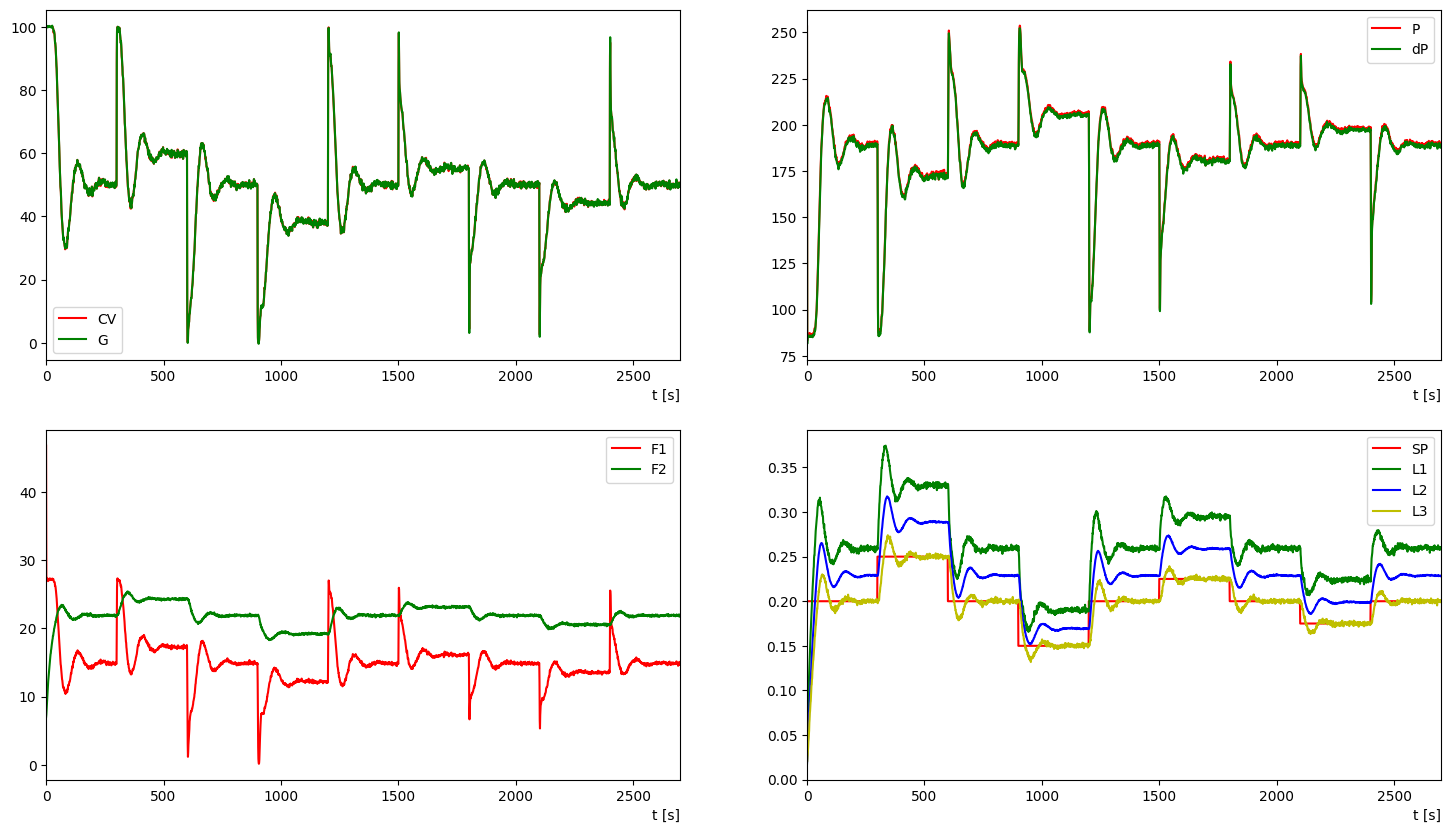

In [5]:
import matplotlib.pyplot as plt

xlim = [0, tend]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
ax[0, 0].set_xlabel('t [s]', loc='right')
l1, = ax[0, 0].plot(proc_vars['t'], proc_vars['CV'], label='CV', color='r')
l2, = ax[0, 0].plot(proc_vars['t'], proc_vars['G'], label='G',  color='g')
ax[0, 0].legend(handles=[l1, l2])
ax[0, 0].set_xlim(xlim)

ax[0, 1].set_xlabel('t [s]', loc='right')
l1, = ax[0, 1].plot(proc_vars['t'], proc_vars['P'], label='P', color='r')
l2, = ax[0, 1].plot(proc_vars['t'], proc_vars['dP'], label='dP', color='g')
ax[0, 1].legend(handles=[l1, l2])
ax[0, 1].set_xlim(xlim)

ax[1, 0].set_xlabel('t [s]', loc='right')
l1, = ax[1, 0].plot(proc_vars['t'], proc_vars['F1'], label='F1', color='r')
l2, = ax[1, 0].plot(proc_vars['t'], proc_vars['F2'], label='F2', color='g')
ax[1, 0].legend(handles=[l1, l2])
ax[1, 0].set_xlim(xlim)

ax[1, 1].set_xlabel('t [s]', loc='right')
l1, = ax[1, 1].plot(proc_vars['t'], proc_vars['SP'], label='SP', color='r')
l2, = ax[1, 1].plot(proc_vars['t'], proc_vars['L1'], label='L1', color='g')
l3, = ax[1, 1].plot(proc_vars['t'], proc_vars['L2'], label='L2', color='b')
l4, = ax[1, 1].plot(proc_vars['t'], proc_vars['L3'], label='L3', color='y')
ax[1, 1].legend(handles=[l1, l2, l3, l4])
ax[1, 1].set_xlim(xlim)

# Przykład 7: wizualizacja dodatkowych sygnałów (e, dist) na podstawie zapisanych danych z symulacji

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
ax[0].set_xlabel('t [s]', loc='right')
l1, = ax[0].plot(proc_vars['t'], proc_vars['e'], label='e')
ax[0].legend(handles=[l1])

ax[1].set_xlabel('t [s]', loc='right')
l1, = ax[1].plot(proc_vars['t'], proc_vars['dist'], label='dist')
ax[1].legend(handles=[l1])

 # Przykład 8: wizualizacja dwóch sygnałów na oddzielnych wykresach

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

ax[0].set_xlabel('t [s]', loc='right')
l1, = ax[0].plot(proc_vars['t'], proc_vars['L3'], label='L3', color='r')
ax[0].legend(handles=[l1])

ax[1].set_xlabel('t [s]', loc='right')
l1, = ax[1].plot(proc_vars['t'], proc_vars['F2'], label='F2', color='g')
ax[1].legend(handles=[l1])

# Przykład 9: wizualizacja dwóch sygnałów na jednym wykresie

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 5))
ax.set_xlabel('t [s]', loc='right')
l1, = ax.plot(proc_vars['t'], proc_vars['L2'], label='L2', color='r')
l2, = ax.plot(proc_vars['t'], proc_vars['L3'], label='L3', color='g')
ax.legend(handles=[l1, l2])